# Zadania
1. Utwórz dwie nowe kolumny w ramce "Countries", w których powierzchnia i gęstość zaludnienia wyrażone sa odpowiednio w milach kwadratowych i osobach na milę kwadratową. 
  - Przelicznik: 1 mila kwadratowa = 0.38610 km kwadratowego (powierzchnię należy pomnożyć, a gęstość zaludnienia podzielić przez ten współczynnik)
  - Typami nowych kolumn mają być odpowiednio integer (powierzchnia) i float (gęstość). Zaokrąglanie do integer: "int(x)"
  - Nazwy nowych kolumn proszę ustawić odpowiednio na '<tt>Area (sq mi)</tt>' oraz '<tt>Pop Density (per sq mi)</tt>'
2. Na wykresie scatterplot narysuj zależność liczby lotnisk od powierzchni kraju. 
  - Dane potrzebne do wykresu są w dwóch ramkach (Countries i Airports), konieczne więc będzie ich złączenie (join).
  - Wskazówka: w pierwszym etapie stwórz ramkę agregującą liczbę lotnisk w zależności od kraju. W drugim etapie złącz (join) tę ramkę z ramką countries. Kolumną wspólną (warunkiem złączenia) będzie Country.
  - Nie zawsze nazwy tych samych krajów będą identyczne w obu ramkach, co może stanowić problem (złączenie nie powstanie). Zastanów się jak przy pomocy mechanizmu złączeń wykryć, które nazwy się różnią. Stwórz odpowiednią ramkę, która zawiera takie nazwy. 
  - Następnie zmień nazwy kilku największych państw w jednej z ramek, tak żeby ujednolicić nazwy. Można to zrobić funkcją replace:
<br><tt>cdf=cdf.replace(['Korea, South', 'Korea, North'], ['South Korea', 'North Korea'], 'Country')</tt>
3. Do ramki "Countries" dodaj nową kolumnę "Continent" (według klasyfikacji Africa, Asia, Europe, North America, South America, Antarctica, Australia/Oceania). 
  - Skorzystaj z kolumny "Region" i pomocniczej funkcji (UDF) mapującej region na kontynent.
4. Oblicz, ile lotnisk jest na poszczególnych kontynentach. To zadanie również wymaga złączenia ramek "Countries" i "Airports". Wynik przedstaw na wykresie słupkowym.


In [1018]:
from pyspark.sql import SparkSession

In [1019]:
import pandas as pd

In [1020]:
import numpy as np

In [1021]:
spark = SparkSession.builder.getOrCreate()

In [1022]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [1023]:
# Wbudowane funkcje, które mogą być przydatne:
# - udf: służy do tworzenia funkcji użytkownika
# - trim: usuwa białe spacje z początku i końca stringu
# - isnull: testuje, czy wartość jest pusta
from pyspark.sql.functions import col, udf, trim, isnull
from pyspark.sql.types import FloatType, IntegerType
import pyspark.sql.functions as F

In [1024]:
def to_float(s):
   return float(s.replace(',','.'))
float_udf = udf(to_float, FloatType())

In [1025]:
countries = spark.read.csv("countries of the world.csv", inferSchema=True, header=True)

# Usuwa kropki z wszystkich nazw kolumn (powodują wiele błędów, prawdopodobnie bug w Sparku)
# (Nb. wszystkie inne metody zmiany tych nazw (np. użycie columnRenamed) zawiodły)
new_columns = [s.replace('.','') for s in countries.columns]
countries = countries.toDF(*new_columns) # tutaj '*' to operator "splat" -- robi z tablicy listę argumentów

# Tak można ustawić wyświetlanie większej liczby wierszy w Jupyterze
pd.set_option('display.max_rows', 20)
display(countries.toPandas())

,Country,Region,Population,Area (sq mi),Pop Density (per sq mi),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",None,None,None
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,"419,9","0,00","2,98","19,62",800.0,None,"145,2","16,9","18,97","64,13",3,"31,67","3,92","0,09","0,28","0,63"
223,Western Sahara,NORTHERN AFRICA,273008,266000,"1,0","0,42",None,None,NaN,None,None,"0,02",0,"99,98",1,None,None,None,None,"0,4"
224,Yemen,NEAR EAST,21456188,527970,"40,6","0,36",0,"61,5",800.0,"50,2","37,2","2,78","0,24","96,98",1,"42,89","8,3","0,135","0,472","0,393"
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,"15,3","0,00",0,"88,29",800.0,"80,6","8,2","7,08","0,03","92,9",2,41,"19,93","0,22","0,29","0,489"


In [1026]:
# Utworzenie nowej ramki 'cdf':
# - wartosci puste wypelnione "-1", zeby nie usuwac wierszy
# - trim stringów (w nazwach występują niepożądane spacje na końcu)
# - konwersja wszystkich kolumn zmiennoprzecinkowych na float
# - zmiana 'sq mi' na 'sq km', bo w zbiorze wartości są faktycznie w km^2, a nie milach^2
cdf = countries.na.fill("-1").select( 
                 trim(col('Country')).alias('Country'),\
                 trim(col('Region')).alias('Region'),'Population',\
                 col('`Area (sq mi)`').alias('Area (sq km)'),\
                 float_udf('`Pop Density (per sq mi)`').alias('Pop Density (per sq km)'),\
                 float_udf('Coastline (coast/area ratio)').alias('Coastline (coast/area ratio)'),\
                 float_udf('Net migration').alias('Net migration'),\
                 float_udf('Infant mortality (per 1000 births)').alias('Infant mortality (per 1000 births)'),\
                 'GDP ($ per capita)',\
                 float_udf('Literacy (%)').alias('Literacy (%)'),\
                 float_udf('Phones (per 1000)').alias('Phones (per 1000)'),\
                 float_udf('Arable (%)').alias('Arable (%)'),\
                 float_udf('Crops (%)').alias('Crops (%)'),\
                 float_udf('Other (%)').alias('Other (%)'),\
                 float_udf('Birthrate').alias('Birthrate'),\
                 float_udf('Deathrate').alias('Deathrate'),\
                 float_udf('Agriculture').alias('Agriculture'),\
                 float_udf('Industry').alias('Industry'),\
                 float_udf('Service').alias('Service'))

# Zadanie 1: nowe kolumny

In [1027]:
cdf.toPandas()

,Country,Region,Population,Area (sq km),Pop Density (per sq km),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.000000,0.000000,23.059999,163.070007,700.0,36.000000,3.200000,12.13,0.220000,87.650002,46.599998,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.599998,1.260000,-4.930000,21.520000,4500.0,86.500000,71.199997,21.09,4.420000,74.489998,15.110000,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.800000,0.040000,-0.390000,31.000000,6000.0,70.000000,78.099998,3.22,0.250000,96.529999,17.139999,4.61,0.101,0.600,0.298
3,American Samoa,OCEANIA,57794,199,290.399994,58.290001,-20.709999,9.270000,8000.0,97.000000,259.500000,10.00,15.000000,75.000000,22.459999,3.27,-1.000,-1.000,-1.000
4,Andorra,WESTERN EUROPE,71201,468,152.100006,0.000000,6.600000,4.050000,19000.0,100.000000,497.200012,2.22,0.000000,97.779999,8.710000,6.25,-1.000,-1.000,-1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,419.899994,0.000000,2.980000,19.620001,800.0,-1.000000,145.199997,16.90,18.969999,64.129997,31.670000,3.92,0.090,0.280,0.630
223,Western Sahara,NORTHERN AFRICA,273008,266000,1.000000,0.420000,-1.000000,-1.000000,NaN,-1.000000,-1.000000,0.02,0.000000,99.980003,-1.000000,-1.00,-1.000,-1.000,0.400
224,Yemen,NEAR EAST,21456188,527970,40.599998,0.360000,0.000000,61.500000,800.0,50.200001,37.200001,2.78,0.240000,96.980003,42.889999,8.30,0.135,0.472,0.393
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,15.300000,0.000000,0.000000,88.290001,800.0,80.599998,8.200000,7.08,0.030000,92.900002,41.000000,19.93,0.220,0.290,0.489


In [1028]:
cdf = cdf.withColumn('Area (sq mi)', col('Area (sq km)') * 0.38610)\
    .withColumn('Pop Density (per sq mi)', col('Pop Density (per sq km)') / 0.38610)

In [1029]:
cdf = cdf.withColumn('Area (sq mi)', cdf['Area (sq mi)'].cast(IntegerType()))

In [1030]:
cdf.toPandas()

,Country,Region,Population,Area (sq km),Pop Density (per sq km),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),...,Arable (%),Crops (%),Other (%),Birthrate,Deathrate,Agriculture,Industry,Service,Area (sq mi),Pop Density (per sq mi)
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.000000,0.000000,23.059999,163.070007,700.0,36.000000,...,12.13,0.220000,87.650002,46.599998,20.34,0.380,0.240,0.380,249999,124.320124
1,Albania,EASTERN EUROPE,3581655,28748,124.599998,1.260000,-4.930000,21.520000,4500.0,86.500000,...,21.09,4.420000,74.489998,15.110000,5.22,0.232,0.188,0.579,11099,322.714319
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.800000,0.040000,-0.390000,31.000000,6000.0,70.000000,...,3.22,0.250000,96.529999,17.139999,4.61,0.101,0.600,0.298,919589,35.742036
3,American Samoa,OCEANIA,57794,199,290.399994,58.290001,-20.709999,9.270000,8000.0,97.000000,...,10.00,15.000000,75.000000,22.459999,3.27,-1.000,-1.000,-1.000,76,752.136736
4,Andorra,WESTERN EUROPE,71201,468,152.100006,0.000000,6.600000,4.050000,19000.0,100.000000,...,2.22,0.000000,97.779999,8.710000,6.25,-1.000,-1.000,-1.000,180,393.939410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,419.899994,0.000000,2.980000,19.620001,800.0,-1.000000,...,16.90,18.969999,64.129997,31.670000,3.92,0.090,0.280,0.630,2262,1087.542072
223,Western Sahara,NORTHERN AFRICA,273008,266000,1.000000,0.420000,-1.000000,-1.000000,NaN,-1.000000,...,0.02,0.000000,99.980003,-1.000000,-1.00,-1.000,-1.000,0.400,102702,2.590003
224,Yemen,NEAR EAST,21456188,527970,40.599998,0.360000,0.000000,61.500000,800.0,50.200001,...,2.78,0.240000,96.980003,42.889999,8.30,0.135,0.472,0.393,203849,105.154101
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,15.300000,0.000000,0.000000,88.290001,800.0,80.599998,...,7.08,0.030000,92.900002,41.000000,19.93,0.220,0.290,0.489,290584,39.627040


# Join examples

In [1031]:
valuesA = [('Pirate',1),('Monkey',2),('Ninja',3),('Spaghetti',4)]
TableA = spark.createDataFrame(valuesA,['name','id'])
 
valuesB = [('Rutabaga',1),('Pirate',2),('Ninja',3),('Darth Vader',4)]
TableB = spark.createDataFrame(valuesB,['name','id'])

In [1032]:
a = TableA.alias('a')
b = TableB.alias('b')

In [1033]:
a.join(b, a.name==b.name).show() # how='inner'

+------+---+------+---+
|  name| id|  name| id|
+------+---+------+---+
| Ninja|  3| Ninja|  3|
|Pirate|  1|Pirate|  2|
+------+---+------+---+



In [1034]:
a.join(b, a.name==b.name, how='left').show()

+---------+---+------+----+
|     name| id|  name|  id|
+---------+---+------+----+
|Spaghetti|  4|  null|null|
|    Ninja|  3| Ninja|   3|
|   Pirate|  1|Pirate|   2|
|   Monkey|  2|  null|null|
+---------+---+------+----+



In [1035]:
a.join(b, a.name==b.name, how='right').show()

+------+----+-----------+---+
|  name|  id|       name| id|
+------+----+-----------+---+
|  null|null|   Rutabaga|  1|
| Ninja|   3|      Ninja|  3|
|Pirate|   1|     Pirate|  2|
|  null|null|Darth Vader|  4|
+------+----+-----------+---+



In [1036]:
a.join(b, a.name==b.name, how='full_outer').show()

+---------+----+-----------+----+
|     name|  id|       name|  id|
+---------+----+-----------+----+
|     null|null|   Rutabaga|   1|
|Spaghetti|   4|       null|null|
|    Ninja|   3|      Ninja|   3|
|   Pirate|   1|     Pirate|   2|
|   Monkey|   2|       null|null|
|     null|null|Darth Vader|   4|
+---------+----+-----------+----+



# Zadanie 2: zależność liczby lotnisk od powierzchni kraju 

In [1037]:
airports = spark.read.csv("airports2.csv", inferSchema=True, header=False)

In [1038]:
airports = airports.toDF('Airport ID', 'Name', 'City', 'Country', 
'IATA', 'ICAO', 'Latitude', 'Longitude', 'Altitude', 'Timezone',
'DST', 'Tz database time zone', 'Type', 'Source'
)

In [1039]:
airports.toPandas()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7179,12053,Rugao Air Base,Rugao,China,RUG,ZSRG,32.257885,120.501656,0,\N,\N,\N,airport,OurAirports
7180,12054,Wuhu Air Base,Wuhu,China,WHU,ZSWU,31.390600,118.408997,0,\N,\N,\N,airport,OurAirports
7181,12055,Shanshan Airport,Shanshan,China,SXJ,ZWSS,42.911701,90.247498,0,\N,\N,\N,airport,OurAirports
7182,12056,Yingkou Lanqi Airport,Yingkou,China,YKH,ZYYK,40.542524,122.358600,0,\N,\N,\N,airport,OurAirports


In [1040]:
# TODO
# zacznij od stworzenia ramki, która zawiera posortowaną liczbę lotnisk w poszczególnych krajach

In [1041]:
import pyspark.sql.functions as func

In [1042]:
sumAirports = airports \
    .groupBy("Country") \
    .agg(func.count("Name").alias("Airports sum")) \
    .select("Country", "Airports sum") \
    .sort("Airports sum") \
    .withColumn("Country", trim(col("Country")))

In [1043]:
sumAirports.toPandas()

,Country,Airports sum
0,Anguilla,1
1,British Indian Ocean Territory,1
2,Jersey,1
3,Norfolk Island,1
4,Saint Helena,1
...,...,...
232,Russia,238
233,Germany,241
234,Australia,296
235,Canada,417


In [1044]:
# TODO złączenie ramek i wykres
# TODO wykrycie niepasujących nazw państwa i ujednolicenie wartości 

In [1045]:
cdf = cdf \
    .withColumn("Country", trim(col("Country")))

In [1046]:
cdf = cdf.replace(('Korea, South', 'Korea, North', 'Bosnia & Herzegovina'), ('South Korea', 'North Korea', 'Bosnia and Herzegovina'), 'Country')

In [1047]:
a = cdf.alias('a')
b = sumAirports.alias('b')

In [1048]:
joined = a.join(b, on=['Country'], how='left')

In [1049]:
joined.toPandas()

,Country,Region,Population,Area (sq km),Pop Density (per sq km),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),...,Crops (%),Other (%),Birthrate,Deathrate,Agriculture,Industry,Service,Area (sq mi),Pop Density (per sq mi),Airports sum
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.000000,0.000000,23.059999,163.070007,700.0,36.000000,...,0.220000,87.650002,46.599998,20.34,0.380,0.240,0.380,249999,124.320124,20.0
1,Albania,EASTERN EUROPE,3581655,28748,124.599998,1.260000,-4.930000,21.520000,4500.0,86.500000,...,4.420000,74.489998,15.110000,5.22,0.232,0.188,0.579,11099,322.714319,5.0
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.800000,0.040000,-0.390000,31.000000,6000.0,70.000000,...,0.250000,96.529999,17.139999,4.61,0.101,0.600,0.298,919589,35.742036,43.0
3,American Samoa,OCEANIA,57794,199,290.399994,58.290001,-20.709999,9.270000,8000.0,97.000000,...,15.000000,75.000000,22.459999,3.27,-1.000,-1.000,-1.000,76,752.136736,2.0
4,Andorra,WESTERN EUROPE,71201,468,152.100006,0.000000,6.600000,4.050000,19000.0,100.000000,...,0.000000,97.779999,8.710000,6.25,-1.000,-1.000,-1.000,180,393.939410,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,419.899994,0.000000,2.980000,19.620001,800.0,-1.000000,...,18.969999,64.129997,31.670000,3.92,0.090,0.280,0.630,2262,1087.542072,1.0
223,Western Sahara,NORTHERN AFRICA,273008,266000,1.000000,0.420000,-1.000000,-1.000000,NaN,-1.000000,...,0.000000,99.980003,-1.000000,-1.00,-1.000,-1.000,0.400,102702,2.590003,3.0
224,Yemen,NEAR EAST,21456188,527970,40.599998,0.360000,0.000000,61.500000,800.0,50.200001,...,0.240000,96.980003,42.889999,8.30,0.135,0.472,0.393,203849,105.154101,11.0
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,15.300000,0.000000,0.000000,88.290001,800.0,80.599998,...,0.030000,92.900002,41.000000,19.93,0.220,0.290,0.489,290584,39.627040,12.0


In [1050]:
not_joined = joined.filter(F.isnull('Airports sum'))

In [1051]:
not_joined.toPandas()

,Country,Region,Population,Area (sq km),Pop Density (per sq km),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),...,Crops (%),Other (%),Birthrate,Deathrate,Agriculture,Industry,Service,Area (sq mi),Pop Density (per sq mi),Airports sum
0,Andorra,WESTERN EUROPE,71201,468,152.100006,0.000000,6.60,4.050000,19000,100.000000,...,0.000000,97.779999,8.710000,6.25,-1.000,-1.000,-1.000,180,393.939410,NaN
1,Antigua & Barbuda,LATIN AMER. & CARIB,69108,443,156.000000,34.540001,-6.15,19.459999,11000,89.000000,...,4.550000,77.269997,16.930000,5.37,0.038,0.220,0.743,171,404.040404,NaN
2,"Bahamas, The",LATIN AMER. & CARIB,303770,13940,21.799999,25.410000,-2.20,25.209999,16700,95.599998,...,0.400000,98.800003,17.570000,9.05,0.030,0.070,0.900,5382,56.462054,NaN
3,British Virgin Is.,LATIN AMER. & CARIB,23098,153,151.000000,52.290001,10.01,18.049999,16000,97.800003,...,6.670000,73.330002,14.890000,4.42,0.018,0.062,0.920,59,391.090391,NaN
4,Central African Rep.,SUB-SAHARAN AFRICA,4303356,622984,6.900000,0.000000,0.00,91.000000,1100,51.000000,...,0.140000,96.760002,33.910000,18.65,0.550,0.200,0.250,240534,17.871018,NaN
5,"Congo, Dem. Rep.",SUB-SAHARAN AFRICA,62660551,2345410,26.700001,0.000000,0.00,94.690002,700,65.500000,...,0.520000,96.519997,43.689999,13.27,0.550,0.110,0.340,905562,69.153071,NaN
6,"Congo, Repub. of the",SUB-SAHARAN AFRICA,3702314,342000,10.800000,0.050000,-0.17,93.860001,700,83.800003,...,0.130000,99.360001,42.570000,12.93,0.062,0.570,0.369,132046,27.972028,NaN
7,"Gambia, The",SUB-SAHARAN AFRICA,1641564,11300,145.300003,0.710000,1.57,72.019997,1700,40.099998,...,0.500000,74.500000,39.369999,12.25,0.308,0.142,0.549,4362,376.327384,NaN
8,Gaza Strip,NEAR EAST,1428757,360,3968.800049,11.110000,1.60,22.930000,600,-1.000000,...,21.049999,50.000000,39.450001,3.80,0.030,0.283,0.687,138,10279.202406,NaN
9,Liechtenstein,WESTERN EUROPE,33987,160,212.399994,0.000000,4.85,4.700000,25000,100.000000,...,0.000000,75.000000,10.210000,7.18,0.060,0.390,0.550,61,550.116534,NaN


<AxesSubplot:xlabel='Area (sq mi)', ylabel='Airports sum'>

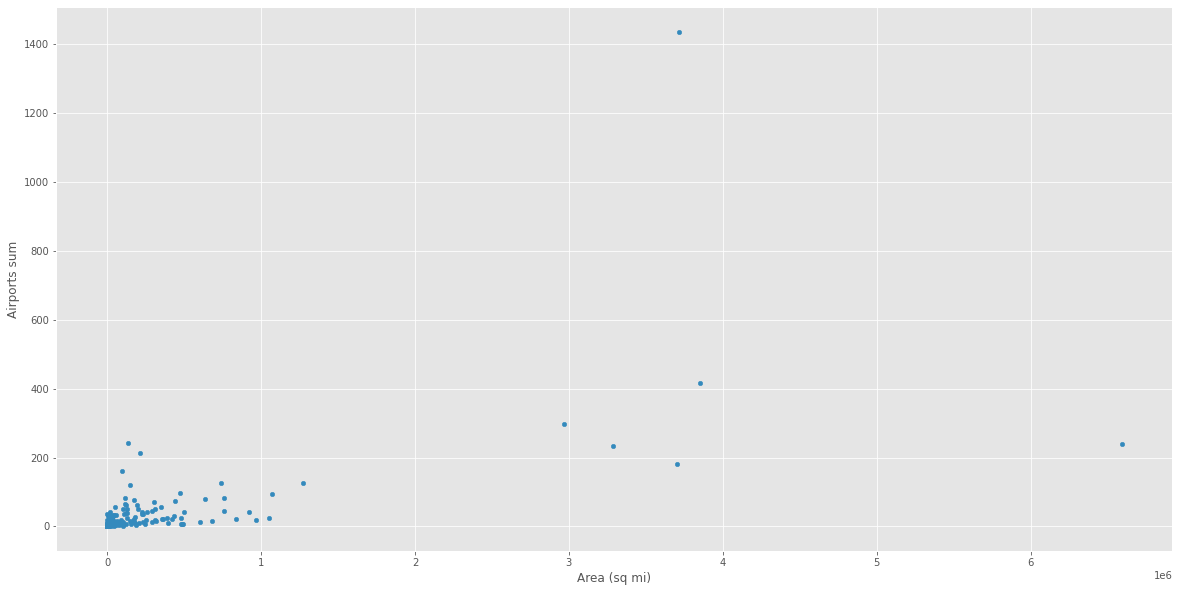

In [1052]:
joined.toPandas().plot.scatter(x="Area (sq mi)", y="Airports sum", figsize=(20, 10))

# Zadanie 3

In [1055]:
countries.toPandas()

,Country,Region,Population,Area (sq mi),Pop Density (per sq mi),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",None,None,None
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,"419,9","0,00","2,98","19,62",800.0,None,"145,2","16,9","18,97","64,13",3,"31,67","3,92","0,09","0,28","0,63"
223,Western Sahara,NORTHERN AFRICA,273008,266000,"1,0","0,42",None,None,NaN,None,None,"0,02",0,"99,98",1,None,None,None,None,"0,4"
224,Yemen,NEAR EAST,21456188,527970,"40,6","0,36",0,"61,5",800.0,"50,2","37,2","2,78","0,24","96,98",1,"42,89","8,3","0,135","0,472","0,393"
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,"15,3","0,00",0,"88,29",800.0,"80,6","8,2","7,08","0,03","92,9",2,41,"19,93","0,22","0,29","0,489"


In [1056]:
countries = countries.withColumn('Continent', trim(col('Region')))

In [1057]:
asia = ['ASIA (EX. NEAR EAST)', 
        'C.W. OF IND. STATES', 
        'NEAR EAST',]
europe = ['BALTICS', 
        'EASTERN EUROPE', 
        'WESTERN EUROPE',]
south_america = ['LATIN AMER. & CARIB',]
north_america = ['NORTHERN AMERICA',]
australia = ['OCEANIA',]
africa = ['SUB-SAHARAN AFRICA', 
        'NORTHERN AFRICA',]

In [1058]:
def get_continent(region):
    if region in asia:
        return 'Asia'
    elif region in europe:
        return 'Europe'
    elif region in south_america:
        return 'South America'
    elif region in north_america:
        return 'North America'
    elif region in australia:
        return 'Australia/Oceania'
    elif region in africa:
        return 'Africa'


In [1059]:
get_continent_udf = udf(get_continent, StringType())

In [1060]:
countries_continents = countries.withColumn(
    'Continent',
    get_continent_udf('Continent')
)

In [1061]:
countries_continents.toPandas()

,Country,Region,Population,Area (sq mi),Pop Density (per sq mi),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),...,Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service,Continent
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0",...,"12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38",Asia
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5",...,"21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579",Europe
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0",...,"3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298",Africa
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0",...,10,15,75,2,"22,46","3,27",None,None,None,Australia/Oceania
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0",...,"2,22",0,"97,78",3,"8,71","6,25",None,None,None,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,"419,9","0,00","2,98","19,62",800.0,None,...,"16,9","18,97","64,13",3,"31,67","3,92","0,09","0,28","0,63",Asia
223,Western Sahara,NORTHERN AFRICA,273008,266000,"1,0","0,42",None,None,NaN,None,...,"0,02",0,"99,98",1,None,None,None,None,"0,4",Africa
224,Yemen,NEAR EAST,21456188,527970,"40,6","0,36",0,"61,5",800.0,"50,2",...,"2,78","0,24","96,98",1,"42,89","8,3","0,135","0,472","0,393",Asia
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,"15,3","0,00",0,"88,29",800.0,"80,6",...,"7,08","0,03","92,9",2,41,"19,93","0,22","0,29","0,489",Africa


# Zadanie 4

In [1063]:
joined = joined.withColumn('Continent', trim(col('Region')))

In [1064]:
joined = joined.withColumn(
    'Continent',
    get_continent_udf('Continent')
)

In [1065]:
joined.toPandas()

,Country,Region,Population,Area (sq km),Pop Density (per sq km),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),...,Other (%),Birthrate,Deathrate,Agriculture,Industry,Service,Area (sq mi),Pop Density (per sq mi),Airports sum,Continent
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.000000,0.000000,23.059999,163.070007,700.0,36.000000,...,87.650002,46.599998,20.34,0.380,0.240,0.380,249999,124.320124,20.0,Asia
1,Albania,EASTERN EUROPE,3581655,28748,124.599998,1.260000,-4.930000,21.520000,4500.0,86.500000,...,74.489998,15.110000,5.22,0.232,0.188,0.579,11099,322.714319,5.0,Europe
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.800000,0.040000,-0.390000,31.000000,6000.0,70.000000,...,96.529999,17.139999,4.61,0.101,0.600,0.298,919589,35.742036,43.0,Africa
3,American Samoa,OCEANIA,57794,199,290.399994,58.290001,-20.709999,9.270000,8000.0,97.000000,...,75.000000,22.459999,3.27,-1.000,-1.000,-1.000,76,752.136736,2.0,Australia/Oceania
4,Andorra,WESTERN EUROPE,71201,468,152.100006,0.000000,6.600000,4.050000,19000.0,100.000000,...,97.779999,8.710000,6.25,-1.000,-1.000,-1.000,180,393.939410,NaN,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,West Bank,NEAR EAST,2460492,5860,419.899994,0.000000,2.980000,19.620001,800.0,-1.000000,...,64.129997,31.670000,3.92,0.090,0.280,0.630,2262,1087.542072,1.0,Asia
223,Western Sahara,NORTHERN AFRICA,273008,266000,1.000000,0.420000,-1.000000,-1.000000,NaN,-1.000000,...,99.980003,-1.000000,-1.00,-1.000,-1.000,0.400,102702,2.590003,3.0,Africa
224,Yemen,NEAR EAST,21456188,527970,40.599998,0.360000,0.000000,61.500000,800.0,50.200001,...,96.980003,42.889999,8.30,0.135,0.472,0.393,203849,105.154101,11.0,Asia
225,Zambia,SUB-SAHARAN AFRICA,11502010,752614,15.300000,0.000000,0.000000,88.290001,800.0,80.599998,...,92.900002,41.000000,19.93,0.220,0.290,0.489,290584,39.627040,12.0,Africa


In [1066]:
joined = joined \
    .groupBy("Continent") \
    .agg(F.sum("Airports sum").alias("Airports sum")) \
    .select("Continent", "Airports sum") \
    .sort("Airports sum") \
    .withColumn("Continent", trim(col("Continent")))

In [1067]:
joined.toPandas()

,Continent,Airports sum
0,Australia/Oceania,542
1,Africa,655
2,South America,921
3,Europe,1395
4,Asia,1662
5,North America,1875


<AxesSubplot:xlabel='Continent'>

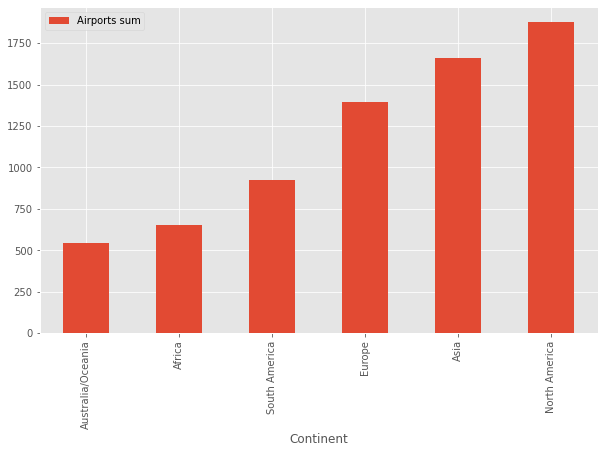

In [1068]:
joined.toPandas().plot.bar(x="Continent", y="Airports sum", figsize=(10, 6))